# Введение в анализ данных
## НИУ ВШЭ, 2020-2021 учебный год

### Домашнее задание №8

In [2]:
import numpy as np
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Градиентный бустинг своими руками (2 + 2* баллов)

Реализуйте алгоритм градиентного бустинга для регрессии. Напомним основные формулы.

Обозначим текущую композицию на $N-1$ шаге за $a_{N - 1}(x_i)$. Следующий базовый алгоритм $b_N(x_i)$ обучается на ответах $-\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)}$, где $L(y_i, z)$ — значение функции потерь на объекте при правильном ответе $y_i$ и предсказании $z$. Композиция на следующем шаге получается следующим образом:

$$
a_N(x_i) = a_{N-1}(x_i) + \nu\gamma_Nb_N(x_i)
$$

Здесь $\nu$ — гиперпараметр learning rate, $\gamma_N$ — оптимальный вес, настраиваемый на каждом шаге алгоритма, который можно найти по следующей формуле (обратите внимание на отсутствие $\nu$):

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$

Можете принять $\gamma_N = 1$ для каждого $N$. Реализуйте нахождение оптимального $\gamma_N$ на каждом шаге, чтобы получить ещё 1 балл.

В качестве функции потерь возьмите MSE.

*Примечание. Вы можете использовать `DecisionTree` из `sklearn` и методы оптимизации из различных библиотек.*

In [4]:
# это может помочь вам для поиска оптимальных gamma
from scipy.optimize import minimize

In [144]:
class GradientBoosting:
    def __init__(self, n_estimators = 100, max_depth = 3, learning_rate = 0.1, gamma = 1, task="Не"):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.models = []
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.task = task
        
    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self
    
    def get_params(self, deep = True):
        return {
            'n_estimators' : self.n_estimators,
            'max_depth' : self.max_depth,
            'learning_rate' : self.learning_rate,
            'gamma' : self.gamma
        }
    
    def fit(self, x, y):
        
        y_pred = 0
        for i in range(self.n_estimators):
            y_new = y - y_pred
            y_pred_new = self._fit_predict_tree(x, y_new)
            
            if self.task == "Optimize gamma":
                self.gamma = minimize(lambda g: mean_squared_error(y, y_pred +  g * y_pred_new), 1).x
            
            y_pred = y_pred + self.gamma * self.learning_rate * y_pred_new
            self.models[i][0] = self.gamma * self.learning_rate

    def _fit_predict_tree(self, x, y):
        
        tree = DecisionTreeRegressor(max_depth = self.max_depth)
        tree.fit(x, y)
        self.models.append([0, tree])
        
        return tree.predict(x)
        
        
    def predict(self, x):

        y_pred = 0        
        for i in range(self.n_estimators):
            y_pred +=   self.models[i][0] * self.models[i][1].predict(x)
            
        return y_pred
       

Проверьте вашу реализацию на Boston dataset. Подберите оптимальные гиперпараметры, чтобы победить RandomForestRegressor как в обычном случае, так и при нахождении оптимального шага **(не меняйте параметры сида)**. При необходимости воспользуйтесь GridSearch. За это вы получите ещё 1 балл.

In [136]:
from sklearn.model_selection import GridSearchCV

In [28]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [166]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=4, n_estimators=640, random_state=19052019)

rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

9.63198271791959

In [157]:
from sklearn.metrics import make_scorer

mse = make_scorer(mean_squared_error, greater_is_better = False)

In [158]:
# Постараемся улучшить нормальным GridSearchем
np.random.seed(19052019)
param_test = {
    'n_estimators' : range(1, 400, 50),
    'max_depth' : [3, 4, 5, 6, 7, 8, 9],
    'learning_rate' : [0.1, 0.3, 0.4, 0.5, 0.6],
    'gamma' : [0.1, 0.3, 0.4, 0.5, 0.6]
}
gsearch = GridSearchCV(estimator = GradientBoosting(), 
                       param_grid = param_test, 
                       scoring= mse,
                       n_jobs=4, 
                       cv=5)

gsearch.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=<__main__.GradientBoosting object at 0x122d81730>,
             n_jobs=4,
             param_grid={'gamma': [0.1, 0.3, 0.4, 0.5, 0.6],
                         'learning_rate': [0.1, 0.3, 0.4, 0.5, 0.6],
                         'max_depth': [3, 4, 5, 6, 7, 8, 9],
                         'n_estimators': range(1, 400, 50)},
             scoring=make_scorer(mean_squared_error, greater_is_better=False))

In [160]:
gsearch.best_params_, gsearch.best_score_

({'gamma': 0.4, 'learning_rate': 0.4, 'max_depth': 3, 'n_estimators': 101},
 -8.360235240022913)

Как-то не очень прикольно вышло. Попробуем по-другому

In [139]:
np.random.seed(19052019)

# ГридСерчи_2.0 без оптимизации
best = [-1, 0]
for i in range(1, 400, 50):
    for j in [3, 4, 5, 6, 7, 8, 9]:
        rg = GradientBoosting(n_estimators=i, max_depth=j, task = "Брат давай без оптимизации")
        rg.fit(X_train, y_train)
        mse = mean_squared_error(y_test, rg.predict(X_test))
        if best[0] < 0 or best[0] > mse:
            best[0] = mse
            best[1] = [i, j]

In [140]:
print(f"Best score {best[0]} with n_estimators = {best[1][0]}, max_depth = {best[1][1]}")

Best score 9.377332613535994 with n_estimators = 301, max_depth = 6


In [131]:
np.random.seed(19052019)

# ГридСерчи_2.0 с оптимизацией
best = [-1, 0]
for i in range(1, 400, 50):
    for j in [3, 4, 5, 6, 7, 8, 9]:
        rg = GradientBoosting(n_estimators=i, max_depth=j, task = "Optimize gamma")
        rg.fit(X_train, y_train)
        mse = mean_squared_error(y_test, rg.predict(X_test))
        if best[0] < 0 or best[0] > mse:
            best[0] = mse
            best[1] = [i, j]

In [133]:
print(f"Best score {best[0]} with n_estimators = {best[1][0]}, max_depth = {best[1][1]}")

Best score 9.367332613535995 with n_estimators = 301, max_depth = 6


Можно сказать что нам удалось)

## Прогнозируем задержки самолётов (2 балла)

Поработаем с задачей про задержки самолётов. На основании доступных данных о рейсе вам нужно определить, будет ли он задержан на 15 минут.
Воспользуйтесь любыми методами градиентного бустинга {XGboost, catboost, LightGBM} и GridSearch для достижения результата. Получите 1 балл за преодоление порога roc_auc_score 0.72 и ещё 1 балл за преодоление порога 0.74.

In [38]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [39]:
train = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering/flight_delays_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering/flight_delays_test.csv')

In [40]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [42]:
# Encoder ругается, так как в тесте данные есть оличные от теста данные
# Исключим их из нашего анализа
for i in train.columns.drop(["DepTime", "Distance", "dep_delayed_15min", "UniqueCarrier", "Origin", "Dest"]):
    le = LabelEncoder()
    test[i] = le.fit_transform(test[i])
    train[i] = le.transform(train[i])

In [43]:
train

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,10,13,6,1934,AA,ATL,DFW,732,N
1,6,12,2,1548,US,PIT,MCO,834,N
2,11,11,4,1422,XE,RDU,CLE,416,N
3,2,17,5,1015,OO,DEN,MEM,872,N
4,1,28,5,1828,WN,MDW,OMA,423,Y
...,...,...,...,...,...,...,...,...,...
99995,7,25,2,1618,OO,SFO,RDD,199,N
99996,0,9,2,804,CO,EWR,DAB,884,N
99997,0,16,1,1901,NW,DTW,IAH,1076,N
99998,6,19,3,1515,MQ,DFW,GGG,140,N


In [44]:
X_train = train.drop(['dep_delayed_15min',"UniqueCarrier", "Origin", "Dest" ], axis=1)
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test.drop(["UniqueCarrier", "Origin", "Dest"], axis=1)
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

Воспользуемся следующим алгоритмом подбора гиперпараметров с семинара:

* Выбираем относительно большую learning_rate ($ \eta \in [0.05, 0.3]$), подбираем оптимальное число деревьев для выбранного $ \eta $

* Настраиваем параметры деревьев, начиная с самых значимых (max_depth, min_child_weight (минимальное количество объектов в листе), gamma (насколько должен уменьшится лос чтобы добавили нове дерево), subsample, colsample_bytree (процент фичей в каждом листе))

* Настраиваем регуляризации ($ \lambda, \alpha $)

* Уменьшаем learning_rate, пропорционально увеличиваем число деревьев

In [45]:
from sklearn.model_selection import GridSearchCV

In [46]:
param_test1 = {
    'max_depth':[2,3, 4, 5, 6, 7, 8],
    'min_child_weight':[2,3,4,5,6,7]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=150,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                       param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)

gsearch1.fit(X_train_part, y_train_part)

[19:19:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=150, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, seed=27,
                                     subsample=None, t

In [47]:
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 6, 'min_child_weight': 7}, 0.7181055951862332)

In [48]:
param_test2 = {
    'gamma': np.linspace(0,1,7)
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=150, max_depth=6,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27, min_child_weight= 7), 
                       param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch2.fit(X_train_part,y_train_part)

[19:21:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=6, min_child_weight=7,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=150, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, seed=27,
                                     subsample=None, tree_me

In [49]:
gsearch2.best_params_, gsearch2.best_score_

({'gamma': 0.0}, 0.7181055951862332)

In [50]:
param_test3 = {
    'subsample': [0.6,0.7,0.8,0.9,1.]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=150, max_depth=6,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27, min_child_weight= 7, 
                                                  gamma = 0), 
                       param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch3.fit(X_train_part,y_train_part)

[19:22:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=0,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=6, min_child_weight=7,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=150, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, seed=27,
                                     subsample=None, tree_metho

In [51]:
gsearch3.best_params_, gsearch3.best_score_

({'subsample': 0.9}, 0.7181827900913459)

In [52]:
param_test4 = {
    'colsample_bytree': [0.6,0.7,0.8,0.9,1.]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=150, max_depth=6,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27, min_child_weight= 7, 
                                                  gamma = 0,subsample= 0.9), 
                       param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch4.fit(X_train_part,y_train_part)

[19:23:34] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=0,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=6, min_child_weight=7,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=150, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, seed=27, subsample=0.9,
                                     tree_method

In [53]:
gsearch4.best_params_, gsearch4.best_score_

({'colsample_bytree': 0.6}, 0.720900902910288)

In [54]:
param_test5 = {
    'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=150, max_depth=6,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27, min_child_weight= 7, 
                                                  gamma = 0, subsample= 0.9, colsample_bytree = 0.6 ), 
                       param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch5.fit(X_train_part,y_train_part)

[19:24:23] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.6, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=6, min_child_weight=7,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=150, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, seed=27, subsample=0.9,
                                     tree_method=

In [55]:
gsearch5.best_params_, gsearch5.best_score_

({'reg_alpha': 0.01}, 0.7212683256392721)

In [56]:
param_test6 = {
    'learning_rate': [0.01, 0.05, 0.1],
    "n_estimators" : [15, 30, 45, 50, 65, 70, 85, 100, 125, 150]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier(max_depth=6,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27, min_child_weight= 7, 
                                                  gamma = 0,subsample= 0.9, colsample_bytree = 0.6, reg_alpha=0.01 ), 
                       param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch6.fit(X_train_part,y_train_part)

[19:26:07] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.6, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=6, min_child_weight=7,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=0.01, reg_lambda=None,
                                     scale_pos_weight=1, seed=27, subsample=0.9,
                                     tree_method

In [57]:
gsearch6.best_params_, gsearch6.best_score_

({'learning_rate': 0.1, 'n_estimators': 150}, 0.7212683256392721)

In [59]:
check = XGBClassifier(max_depth=6,
              objective= 'binary:logistic', 
              nthread=4, 
              scale_pos_weight=1,
              seed=27, 
              min_child_weight= 7, 
              gamma = 0,
              subsample= 0.9, 
              colsample_bytree = 0.6, 
              reg_alpha=0.01)

check.fit(X_train_part,y_train_part)
roc_auc_score(y_valid, check.predict_proba(X_valid)[:, 1])

[19:28:08] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7206813012657434

Видимо это максимум XGBClassifier, попробуем воспользоваться CatBoostClassifier

In [60]:
train = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering/flight_delays_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering/flight_delays_test.csv')

X_train = train.drop('dep_delayed_15min', axis=1)
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = train.drop('dep_delayed_15min', axis=1)
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

In [61]:
cat_features = []
for i in range(len(X_train.columns)):
    if type(train[X_train.columns[i]][0]) is str:
        cat_features.append(i)

In [62]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=200,
    random_seed=63,
    learning_rate=0.8,
    verbose=False
)
model.fit(
    X_train_part, y_train_part,
    cat_features=cat_features,
    eval_set=(X_valid, y_valid),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [63]:
print(f' Оптимальное количество деревьев: {model.tree_count_}')

 Оптимальное количество деревьев: 52


In [64]:
my_best_model = CatBoostClassifier(
    iterations=52,
    random_seed=63,
    learning_rate=0.8)

my_best_model.fit(
    X_train, y_train,
    eval_set=(X_valid, y_valid),
    cat_features=cat_features,
    verbose=False)

In [65]:
roc_auc_score(y_valid, my_best_model.predict_proba(X_valid)[:, 1])

0.744518983055841

С задачей справились, перешагнули благодаря CatBoostClassifier ))))

## DBSCAN своими руками (2 + 2* баллов)

DBSCAN: Density-based spatial clustering of applications with noise

Реализуйте класс dbscan.

Алгоритм имеет два основных гиперпараметра:
1. `eps` &mdash; радиус рассматриваемой окрестности
2. `min_samples` &mdash; число соседей в окрестности

Для выполнения кластеризации DBSCAN точки делятся на основные точки, достижимые по плотности точки и выпадающие следующим образом:

- Точка $p$ является основной точкой, если по меньшей мере `min_samples` точек находятся на расстоянии, не превосходящем 
`eps` от неё. Говорят, что эти точки достижимы прямо из $p$.

-  Точка $q$ прямо достижима из $p$, если точка $q$ находится на расстоянии, не большем `eps`, от точки $p$, и $p$ — основная точка.
Точка $q$ достижима из $p$, если имеется путь 
$p_1,…,p_n$ где $p_1=p$ и $p_n=q$ , а каждая точка $p_{i+1}$ достижима прямо из $p_i$ (все точки на пути должны быть основными, за исключением $q$).

Все точки, не достижимые из основных точек, считаются выбросами.

Теперь, если $p$ является основной точкой, то она формирует кластер вместе со всеми точками (основными или неосновными), достижимыми из этой точки. Каждый кластер содержит по меньшей мере одну основную точку. Неосновные точки могут быть частью кластера, но они формируют его «край», поскольку не могут быть использованы для достижения других точек.


In [66]:
from scipy.spatial import distance
from queue import Queue
import numpy as np

In [68]:
class dbscan:
    def __init__(self, eps, min_samples):
        # your code here
        self.eps = eps
        self.min_samples = min_samples
        self.cluster_label = 0
        self.noise = 0
        
    def fit_predict(self, X):
        
        # Если же соседей достаточно, будем строить от неё кластер с помощью grow_cluster()
        # your code here
        
        # Помечаем переданные точки, чтобы отличать уже кластеризованные
        # или являющиеся шумом от остальных
        X = np.append(X, np.array([[-1]*len(X)]).reshape(-1,1), axis=1)
        self.X = X
        
        # Реализуем цикл по точкам, игнорирущий уже кластеризованные
        for x in range(len(X)):
            if X[x][2] != -1:
                continue
            
            # Если точка ещё не кластеризована, с помощью range_query() ищем её соседей
            point = X[x,:2]
            bros = self.range_query(point)
            
            # Если соседей недостаточно, то помечаем её выделенным под шум лейблом
            if len(bros) < self.min_samples:
                X[x][2] = self.noise
                continue
            
            self.grow_cluster(x, bros)
        
        self.clusters = X[:,2]
        self.X = X 
        return self.clusters
            

    def grow_cluster(self, root, neighbours):
        # В этой функции мы полностью строим кластер относительно переданной точки
        # Т.е. реализуем цикл по структуре данных, изначально состоящей из уже
        # известных соседей (neighbours) и в процессе пополняющейся
        # "соседями соседей" с помощью range_query()
        # !!В данной реализации такой структурой данных выступает очередь
        
        self.cluster_label += 1
        self.X[root][2] = self.cluster_label
        found_bros = neighbours
        q = Queue()
            
        for i in neighbours:
            q.put(i)            
        while q.empty() == False:
            current = q.get()
            if self.X[current,2] == 0: # Если ранее была отмечена как шум
                self.X[current,2] = self.cluster_label
            if self.X[current,2] != -1:  # Если некластеризирофвана
                continue
            self.X[current,2] = self.cluster_label 
            point2 = self.X[current,:2]
            bros2 = self.range_query(point2)
            if len(bros2) >= self.min_samples:
                for x in bros2:
                    if x not in found_bros:
                        q.put(x)
                        found_bros.append(x) 
                                                             

    def range_query(self, x):
        """Возвращает точки на расстоянии <= eps от x"""
        neighbors = []
        for i in range(len(self.X)):
            if self.dist(X[i][:2], x) <= self.eps:
                neighbors.append(i)
        return neighbors
    
    @staticmethod
    def dist(a, b):
        """Метрика расстояния"""
        return float(distance.pdist([a, b]))

Проверим себя на простом примере:

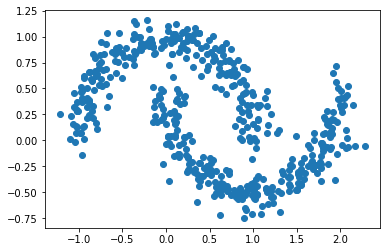

In [79]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd

X, _ = make_moons(n_samples=500, noise=0.1)
plt.scatter(X[:,0], X[:,1])
plt.show()

Кластеризуйте это с помощью своей версии DBSCAN:

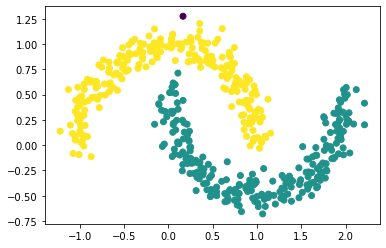

In [71]:
cls = dbscan(eps=0.2, min_samples=10)
clusters = cls.fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

Референс:

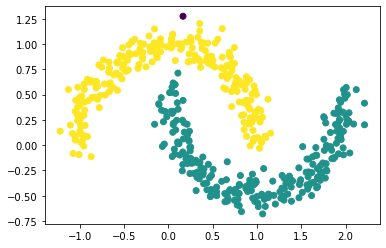

In [72]:
from sklearn.cluster import DBSCAN

clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

Получите 1 балл за ещё один интересный пример кластеризации (в качестве референса используйте предоставленное изображение. Нужно несколько интересных соседствующих форм):

In [73]:
from sklearn import datasets

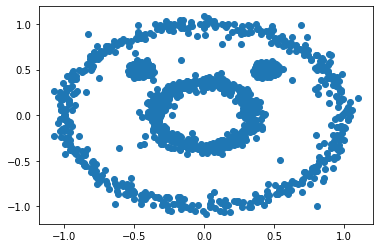

In [74]:
x1, y1 = datasets.make_circles(n_samples=1000, factor=0.35, noise=0.04)
x2, y2 = datasets.make_blobs(n_samples=1000, centers=[[0.45, 0.5]], cluster_std=[[0.03]])
x3, y3 = datasets.make_blobs(n_samples=1000, centers=[[-0.45, 0.5]], cluster_std=[[0.03]])

X = np.concatenate((x1, x2, x3))
noise=np.random.rand(50,2)*2-1
Noisy_Data=np.concatenate((X,noise))

plt.scatter(Noisy_Data[:, 0], Noisy_Data[:, 1])
plt.show;

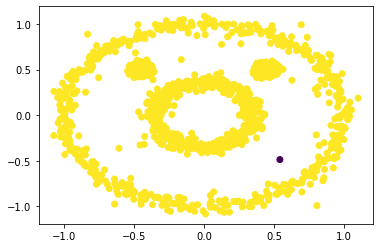

In [76]:
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(Noisy_Data)

plt.scatter(Noisy_Data[:,0], Noisy_Data[:,1], c=clusters)
plt.show()